In [828]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind, chi2_contingency, chi2
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler, LabelEncoder
import time
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler, TomekLinks, OneSidedSelection
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

In [829]:
data = pd.read_csv('data/Bank Customer Churn Prediction.csv')
data.head()

,customer_id,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
0,15634602,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,15647311,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,15619304,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,15701354,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,15737888,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [830]:
data.shape

(10000, 12)

In [831]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customer_id       10000 non-null  int64  
 1   credit_score      10000 non-null  int64  
 2   country           10000 non-null  object 
 3   gender            10000 non-null  object 
 4   age               10000 non-null  int64  
 5   tenure            10000 non-null  int64  
 6   balance           10000 non-null  float64
 7   products_number   10000 non-null  int64  
 8   credit_card       10000 non-null  int64  
 9   active_member     10000 non-null  int64  
 10  estimated_salary  10000 non-null  float64
 11  churn             10000 non-null  int64  
dtypes: float64(2), int64(8), object(2)
memory usage: 937.6+ KB


In [832]:
data.isnull().sum()

customer_id         0
credit_score        0
country             0
gender              0
age                 0
tenure              0
balance             0
products_number     0
credit_card         0
active_member       0
estimated_salary    0
churn               0
dtype: int64

<font size="4">There are no null values</font>

In [833]:
data.shape

(10000, 12)

In [834]:
data = data.drop_duplicates()
data.shape

(10000, 12)

<font size="4">There are no duplicated values</font>

<font size="4">Delete the unnecessary column: customer_id</font>

In [835]:
data = data.drop(columns=['customer_id'])

# EDA

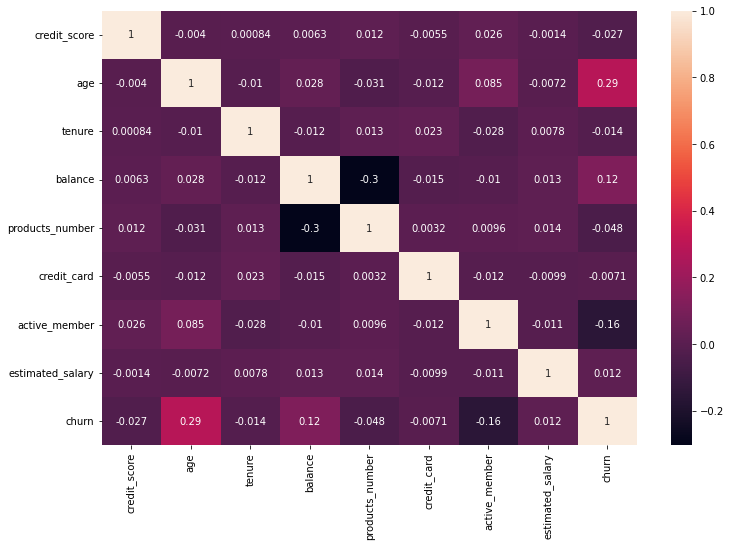

In [836]:
plt.figure(figsize=(12,8))
sns.heatmap(data=data.corr(), annot=True)
plt.show()

<font size="4">Consider the strong correlation (threshold:0.8)</font>

<font size="4">Features show no strong correlations as the chart showed</font>

<font size="4">I will explore the numerical features first: credit_score, age, tenure, products_number, balance, estimated_salary</font>

<font size="4">Notice that, even some type of features are numerical types but the values indicated are binary (0 or 1). So I consider these features as categorical data</font>

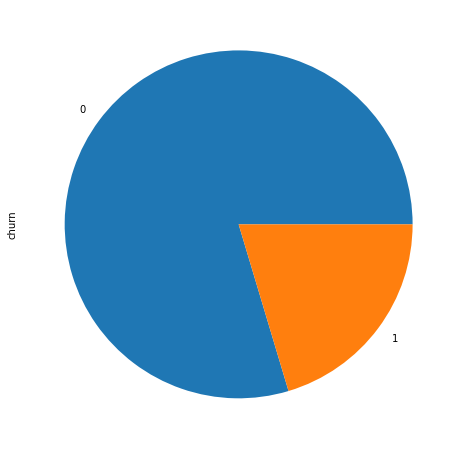

In [837]:
plt.figure(figsize=(8,8))
data.groupby('churn')['churn'].count().plot(kind='pie')
plt.show()

<font size="4">The dataset is imbalanced</font>

In [838]:
lst_num = ['credit_score', 'age', 'tenure', 'products_number', 'balance', 'estimated_salary']

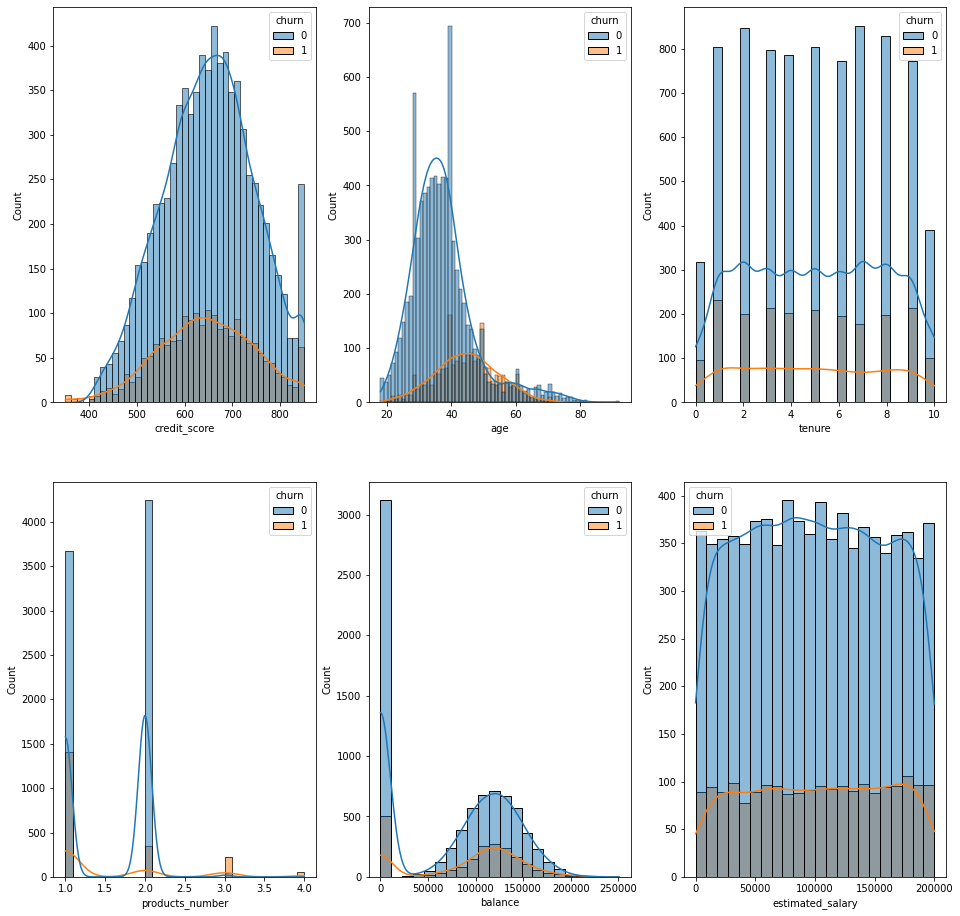

In [839]:
rows = 2
cols = 3
idx = 0
fig, axs = plt.subplots(rows, cols, figsize=(16,16))
for i in range(rows):
    for j in range(cols):
        sns.histplot(ax=axs[i, j], data=data, x=lst_num[idx], hue='churn', kde=True)
        idx += 1

<font size="4">Due to the unbalanced dataset. It is hard to come to a conclusion.</font>
<font size="4">But the charts indicate that</font>

<font size="4">credit_score, balance, tenure and estimated_salary show no differences with the number of customers who churn or not as the distribution of both kind of these features overlapping</font>

<font size="4">With products_number and age, there is a point,</font>

<font size="4">most of customers who churn have bought more than 2 products from the banks while most age of customers around 20 to 50.</font>
<font size="4">However, the dataset is imbalanced. So I gonna perform inferential analytics on all these features to have a better view</font>

* #------------------------------------------Welch's t-test-------------------------------------------------------#

- H0: There are differences between lst_0 and lst_1 aka mean(lst_0) == mean(lst_1)
- Ha: There are NO differences between lst0 and lst_1 aka mean(lst_0) != mean(lst_1)

* #-------------------------------------------------------------------------------------------------------------------#

In [840]:
alpha = .05
for i in lst_num:
    lst_0 = data[i].loc[data['churn'] == 0]
    lst_1 = data[i].loc[data['churn'] == 1]
    t, p = ttest_ind(lst_0, lst_1, equal_var = False)
#--------------------------------------------------------------------------------
    print(f'p-value = {p:.2f}, alpha = {alpha:.2f}')
    if (p < alpha):
        print('p < alpha => reject H0 => there are differences between', i, 'and churn')
    else:
        print('p > alpha => failed to reject H0 => there are NO differences between', i, 'and churn')
    print('\n')

p-value = 0.01, alpha = 0.05
p < alpha => reject H0 => there are differences between credit_score and churn


p-value = 0.00, alpha = 0.05
p < alpha => reject H0 => there are differences between age and churn


p-value = 0.17, alpha = 0.05
p > alpha => failed to reject H0 => there are NO differences between tenure and churn


p-value = 0.00, alpha = 0.05
p < alpha => reject H0 => there are differences between products_number and churn


p-value = 0.00, alpha = 0.05
p < alpha => reject H0 => there are differences between balance and churn


p-value = 0.23, alpha = 0.05
p > alpha => failed to reject H0 => there are NO differences between estimated_salary and churn




<font size="4">As the test indicates, tenure and estimated_salary failed to reject H0 -> So they do not affect to the churning while others show effect</font>

<font size="4">From here, I will remove these features from the dataset</font>

In [841]:
data_new = data.drop(columns=['tenure', 'estimated_salary'])
data_new.head()

,credit_score,country,gender,age,balance,products_number,credit_card,active_member,churn
0,619,France,Female,42,0.00,1,1,1,1
1,608,Spain,Female,41,83807.86,1,0,1,0
2,502,France,Female,42,159660.80,3,1,0,1
3,699,France,Female,39,0.00,2,0,0,0
4,850,Spain,Female,43,125510.82,1,1,1,0


In [842]:
lst_cate = ['country', 'gender', 'credit_card', 'active_member']

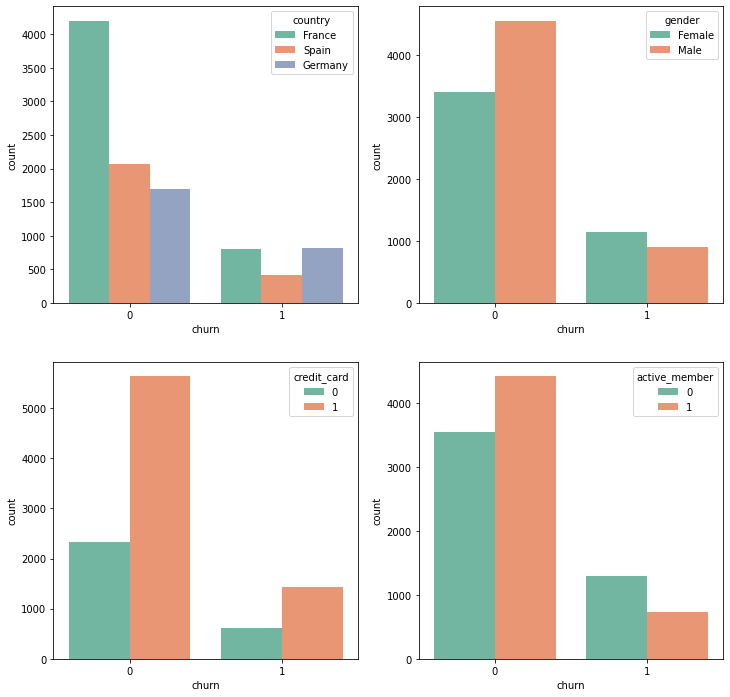

In [843]:
rows = 2
cols = 2
idx = 0
fig, axs = plt.subplots(rows, cols, figsize=(12,12))
for i in range(rows):
    for j in range(cols):
        sns.countplot(ax=axs[i,j], data=data_new, x='churn', hue=lst_cate[idx], palette='Set2')
        idx += 1

<font size="4">All features are affect to the churn decision of customers except for credit_card</font>

<font size="4">The trend of people who have credit card and decided to churn or people who don't have credit card but decided to churn are no diffent and vice versa</font>

<font size="4">I will perform the inferential analytics on these features so I can come to the conclusion</font>

* #------------------------------------------Chi Square Test-------------------------------------------------------#

- H0: lst_0 and lst_1 are DEPENDENT
- Ha: lst0 and lst_1 are INDEPENDENT

* #-------------------------------------------------------------------------------------------------------------------#

In [844]:
alpha = .05
for i in lst_cate:
    table = pd.crosstab(data_new[i], data_new['churn'])
    stat, p, dof, expected = chi2_contingency(table)
#--------------------------------------------------------------------------------
    print(f'p-value = {p:.2f}, alpha = {alpha:.2f}')
    if (p < alpha):
        print('p < alpha => reject H0 => ', i, 'and churn are DEPENDENT')
    else:
        print('p > alpha => failed to reject H0 =>', i, 'and churn are INDEPENDENT')
    print('\n')

p-value = 0.00, alpha = 0.05
p < alpha => reject H0 =>  country and churn are DEPENDENT


p-value = 0.00, alpha = 0.05
p < alpha => reject H0 =>  gender and churn are DEPENDENT


p-value = 0.49, alpha = 0.05
p > alpha => failed to reject H0 => credit_card and churn are INDEPENDENT


p-value = 0.00, alpha = 0.05
p < alpha => reject H0 =>  active_member and churn are DEPENDENT




<font size="4">As I doubted. credit_card and churn are independent. So they are no differences about the churn condition among people who have credit card or not. While other features show a correlation with churn condition</font>

<font size="4">I delete credit_card column from the data to remove the unncessary column for model</font>

In [845]:
final_data = data_new.drop(columns=['credit_card'])
final_data.head()

,credit_score,country,gender,age,balance,products_number,active_member,churn
0,619,France,Female,42,0.00,1,1,1
1,608,Spain,Female,41,83807.86,1,1,0
2,502,France,Female,42,159660.80,3,0,1
3,699,France,Female,39,0.00,2,0,0
4,850,Spain,Female,43,125510.82,1,1,0


# Modelling - Classification

In [846]:
X = final_data.drop(columns=['churn'])
y = final_data['churn']

In [847]:
X = X.replace('Male', 1)
X = X.replace('Female', 0)
print('type of gender column', X['gender'].dtype)
X.head()

type of gender column int64


,credit_score,country,gender,age,balance,products_number,active_member
0,619,France,0,42,0.00,1,1
1,608,Spain,0,41,83807.86,1,1
2,502,France,0,42,159660.80,3,0
3,699,France,0,39,0.00,2,0
4,850,Spain,0,43,125510.82,1,1


In [848]:
ord_encoder = LabelEncoder()
X['country'] = ord_encoder.fit_transform(X['country'])

In [849]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [850]:
mm_scaler = MinMaxScaler()
X_train = mm_scaler.fit_transform(X_train)
X_test = mm_scaler.transform(X_test)

In [851]:
label_yes_before = y_train.where(y_train == 1).count()
label_no_before = y_train.where(y_train == 0).count()
print('label yes before:', label_yes_before)
print('label no before:', label_no_before)

label yes before: 1606
label no before: 6394


In [852]:
ros = RandomOverSampler()
X_train, y_train = ros.fit_resample(X_train, y_train)

In [853]:
label_yes_after = y_train.where(y_train == 1).count()
label_no_after = y_train.where(y_train == 0).count()
print('label yes after:', label_yes_after)
print('label no after:', label_no_after)

label yes after: 6394
label no after: 6394


In [854]:
models= [LogisticRegression(), GaussianNB(), KNeighborsClassifier(n_neighbors=11), 
         RandomForestClassifier(), DecisionTreeClassifier(), 
         AdaBoostClassifier(), XGBClassifier(), SVC()]
scores= []
test_score = []
train_times = []
names= []

In [855]:
for model in models:
    start= time.time()
    scores.append(cross_val_score(model, X_train, y_train, scoring= 'accuracy', cv= 10).mean())
    end = time.time()
    train_times.append(end-start)
    names.append(model.__class__.__name__)

df= pd.DataFrame(scores, columns=['Score'], index= range(len(models)))
df.insert(1, 'Time', pd.Series(train_times))
df.insert(0, 'Model', pd.Series(names))
df

,Model,Score,Time
0,LogisticRegression,0.689397,0.170583
1,GaussianNB,0.727009,0.030917
2,KNeighborsClassifier,0.801222,0.486734
3,RandomForestClassifier,0.951440,24.253880
4,DecisionTreeClassifier,0.927198,1.611674
5,AdaBoostClassifier,0.773383,30.641557
6,XGBClassifier,0.888803,2.244944
7,SVC,0.773696,30.029523


In [856]:
for model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    score = accuracy_score(y_test, y_pred)
    test_score.append(score)    
    cm = classification_report(y_test, y_pred)
    print(model.__class__.__name__)
    print(cm, '\n')
df['Test_Score'] = test_score
df

LogisticRegression
              precision    recall  f1-score   support

           0       0.90      0.69      0.78      1569
           1       0.39      0.71      0.50       431

    accuracy                           0.69      2000
   macro avg       0.64      0.70      0.64      2000
weighted avg       0.79      0.69      0.72      2000
 

GaussianNB
              precision    recall  f1-score   support

           0       0.91      0.77      0.83      1569
           1       0.46      0.73      0.57       431

    accuracy                           0.76      2000
   macro avg       0.69      0.75      0.70      2000
weighted avg       0.82      0.76      0.78      2000
 

KNeighborsClassifier
              precision    recall  f1-score   support

           0       0.92      0.77      0.84      1569
           1       0.48      0.76      0.59       431

    accuracy                           0.77      2000
   macro avg       0.70      0.77      0.71      2000
weighted avg       

,Model,Score,Time,Test_Score
0,LogisticRegression,0.689397,0.170583,0.6925
1,GaussianNB,0.727009,0.030917,0.7595
2,KNeighborsClassifier,0.801222,0.486734,0.7690
3,RandomForestClassifier,0.951440,24.253880,0.8375
4,DecisionTreeClassifier,0.927198,1.611674,0.7995
5,AdaBoostClassifier,0.773383,30.641557,0.7905
6,XGBClassifier,0.888803,2.244944,0.8195
7,SVC,0.773696,30.029523,0.8030


## Stacking model

<font size="4">Now, I will perform the stacking model to see if it can improve the performance</font>

<font size="4">Base on the performance report abow, I chose the three model: Logistic Regression, GaussianNB and KneighborsClassifer as the input model and meta model is DecisionTreeClassifier</font>

In [857]:
lr_model = LogisticRegression()
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict_proba(X_test)

In [858]:
gnb_model = GaussianNB()
gnb_model.fit(X_train, y_train)
y_pred_gnb = gnb_model.predict_proba(X_test)

In [859]:
knn_model = KNeighborsClassifier(n_neighbors=11)
knn_model.fit(X_train, y_train)
y_pred_knn = knn_model.predict_proba(X_test)

In [860]:
df_meta = pd.DataFrame()
y_pred_lr = pd.DataFrame(y_pred_lr)
df_meta['data_lr_0'] = y_pred_lr[0]
df_meta['data_lr_1'] = y_pred_lr[1]
#---------------------------------------
y_pred_gnb = pd.DataFrame(y_pred_gnb)
df_meta['data_gnb_0'] = y_pred_gnb[0]
df_meta['data_gnb_1'] = y_pred_gnb[1]
#---------------------------------------
y_pred_knn = pd.DataFrame(y_pred_knn)
df_meta['data_knn_0'] = y_pred_knn[0]
df_meta['data_knn_1'] = y_pred_knn[1]
#---------------------------------------
df_meta['data_test'] = y_test.reset_index().drop(columns=['index'])
df_meta.head()

,data_lr_0,data_lr_1,data_gnb_0,data_gnb_1,data_knn_0,data_knn_1,data_test
0,0.572894,0.427106,0.557070,0.442930,0.545455,0.454545,0
1,0.730954,0.269046,0.729287,0.270713,0.909091,0.090909,0
2,0.473577,0.526423,0.543746,0.456254,0.181818,0.818182,0
3,0.668900,0.331100,0.752280,0.247720,0.636364,0.363636,0
4,0.820451,0.179549,0.850279,0.149721,0.636364,0.363636,0


In [861]:
X_ = df_meta.drop(columns=['data_test'])
y_ = df_meta['data_test']

In [862]:
X_train_, X_test_, y_train_, y_test_ = train_test_split(X_, y_, test_size=0.2)

In [863]:
meta_model = DecisionTreeClassifier()
meta_model.fit(X_train_, y_train_)
y_pred_meta_ = meta_model.predict(X_test_)
print('accuracy:', accuracy_score(y_test_, y_pred_meta_))

accuracy: 0.8075


In [864]:
cm = classification_report(y_test_, y_pred_meta_)
print(cm, '\n')

              precision    recall  f1-score   support

           0       0.88      0.87      0.88       315
           1       0.54      0.58      0.56        85

    accuracy                           0.81       400
   macro avg       0.71      0.72      0.72       400
weighted avg       0.81      0.81      0.81       400
 

